In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skmlm import NN_MLM,MLM,FCM_MLM,OS_MLM,MLMC
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
sns.set_theme(style="darkgrid")


C:\Users\hamdi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn.datasets import load_iris,load_wine,load_breast_cancer

## 1. Préparations des données

### 1.1 Chargement de données 

In [3]:

# 6 datasets pour la régression 
domain = pd.read_csv("Abalone/abalone.domain",delimiter=":", names=["column","type" ])# Pour charger les noms des dolonnes
abalone = pd.read_csv("Abalone/abalone.data",names=domain.column.to_list()) # charher la dataset, 

domain = pd.read_csv("Auto-Price/price.domain",delimiter=":", names=["column","type","unknow"])
price = pd.read_csv("Auto-Price/price.data",names=domain.column.to_list())

domain = pd.read_csv("Housing/housing.domain",delimiter=":", names=["column","type" ])
housing = pd.read_csv("Housing/housing.data",names=domain.column.to_list())

domain = pd.read_csv("Servo/servo.domain",delimiter=":", names=["column","type" ])
servo = pd.read_csv("Servo/servo.data",names=domain.column.to_list())

# 3 dataset pour la classification
breast_cancer = load_breast_cancer()
iris = load_iris()
wine = load_wine()

In [4]:
print("Les dimensions des données :")
print("Servo         :",servo.shape)
print("Abalone       :",abalone.shape)
print("housing       :",housing.shape)
print("Auto price    :", price.shape)
print("breast_cancer :",breast_cancer.data.shape)
print("iris          :",iris.data.shape)
print("wine          :",wine.data.shape)

Les dimensions des données :
Servo         : (167, 5)
Abalone       : (4177, 9)
housing       : (506, 14)
Auto price    : (159, 16)
breast_cancer : (569, 30)
iris          : (150, 4)
wine          : (178, 13)


In [5]:
servo.head(2)

,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252


In [6]:
abalone.head(2)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


In [7]:
housing.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,class
0,0.006,18.0,2.31,0,0.538,6.575,65.2,4.090,1,296.0,15.3,396.898,4.98,24.0
1,0.027,0.0,7.07,0,0.469,6.421,78.9,4.967,2,242.0,17.8,396.898,9.14,21.6


In [8]:
price.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,13950
1,2,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,17450


### 1.2 Prétraitements

In [9]:
def preprocessing(dataset):
    # séparer les colonnes en deux types catégorielles et numériques
    cat_col=[col for col in dataset.columns if dataset[col].dtype=='object']
    num_col=[col for col in dataset.columns if dataset[col].dtype=='int64' or dataset[col].dtype=='float64']
    # garder uniquement les colonnes catégorielles et supprimer les valeurs manquantes 
    dataset = dataset[num_col].dropna(axis=0)
    # 10 pérmutation aléatoire pour mélanger les données 
    df_shuffled=dataset.sample(frac=1).reset_index(drop=True)
    for i in range(10):
        df_shuffled=df_shuffled.sample(frac=1).reset_index(drop=True)
    data = df_shuffled.to_numpy()
    size = data.shape[1]
    X = data[:,:size-1]
    y = data[:,size-1]
    y = y.reshape((len(y),1))
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3,random_state=42)
    # centrer réduire
    mx,my = x_train.mean(axis=0),y_train.mean(axis=0)
    ecart1,ecart2 = x_train.std(),y_train.std()
    return (x_train-mx)/ecart1,(x_test-mx)/ecart1,(y_train-my)/ecart2,(y_test)

In [10]:
def test(dataset,name):
    L = []
    x_train, x_test, y_train, y_test = preprocessing(dataset)
    if name == "r":
        for i in np.arange(5,105,5):  
            clf = MLM(rp_number=i/100)
            clf.fit(x_train,y_train)
            ypred = clf.predict(x_test)
            L.append((mean_squared_error(ypred,y_test),i/100))
    else :
        for i in np.arange(5,105,5): 
            clf = NN_MLM(rp_number=i/100)
            scores = cross_val_score(clf,x,y,cv=10)
            L.append((scores.mean(),scores.std(),i/100))
        
    return L

## 2. Test sur des problèmes de régressions

### 2.1 Dataset Servo

In [11]:
res = test(servo,"r")[0]
print("Meilleur valeur : {}, Nombre de point références associé : {}".format(res[0],res[1]))

ValueError: not enough values to unpack (expected 4, got 2)

In [6]:
def grid_search_param(x,y,name):
    
    # je définie les paramètres du grid search 
    param_grid = {'C': [2**(-2), 2**(-1), 2**(0), 2**(1), 2**(2),2**(3),2**(4),2**(5),2**(6),2**(7),2**(8),2**(9),2**(10)],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'epsilon':[0.1,0.2,0.5,0.3],
                  'kernel': ['rbf']}

    if name == 'r':
        grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
    elif name =='c':
        param_grid = {'C': [2**(-2), 2**(-1), 2**(0), 2**(1), 2**(2),2**(3),2**(4),2**(5),2**(6),2**(7),2**(8),2**(9),2**(10)],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf']}
        
        grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
    # entrainement du modèle 
    grid.fit(x,y.reshape(len(y))) 
    # affichage des meilleurs hyper paramètres
    print(grid.best_params_) 

    # affciher l'état du modèle avec les meilleurs paramètres trouvés
    print(grid.best_estimator_) 

In [37]:
grid_search_param(x,y)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.557, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.457, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.517, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.645, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.313, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.256, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=-0.002, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.016, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=-0.004, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=-0.351, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf, score=-0.070, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf, score=-0.032, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf, score=-0.011, total=   0.0s
[CV] C=0.25

[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.658, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.369, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.587, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.582, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.365, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=0.5, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.408, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=0.5, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.374, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=0.1, kernel=rbf .....

[CV]  C=1, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.008, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=1, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.009, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=1, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.013, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=1, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.208, total=   0.0s
[CV] C=1, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=1, epsilon=0.3, gamma=1, kernel=rbf, score=0.662, total=   0.0s
[CV] C=1, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=1, epsilon=0.3, gamma=1, kernel=rbf, score=0.367, total=   0.0s
[CV] C=1, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=1, epsilon=0.3, gamma=1, kernel=rbf, score=0.582, total=   0.0s
[CV] C=1, epsilon=0.3, gamma=1, kernel=rbf ......

[CV]  C=2, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.018, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=2, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.023, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=2, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.196, total=   0.0s
[CV] C=2, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.3, gamma=1, kernel=rbf, score=0.670, total=   0.0s
[CV] C=2, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.3, gamma=1, kernel=rbf, score=0.350, total=   0.0s
[CV] C=2, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.3, gamma=1, kernel=rbf, score=0.579, total=   0.0s
[CV] C=2, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.3, gamma=1, kernel=rbf, score=0.593, total=   0.0s
[CV] C=2, epsilon=0.3, gamma=1, kernel=rbf ...........

[CV]  C=4, epsilon=0.5, gamma=0.001, kernel=rbf, score=-0.009, total=   0.0s
[CV] C=4, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.027, total=   0.0s
[CV] C=4, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.028, total=   0.0s
[CV] C=4, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.035, total=   0.0s
[CV] C=4, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.045, total=   0.0s
[CV] C=4, epsilon=0.5, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.174, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=1, kernel=rbf ...........................
[CV]  C=4, epsilon=0.3, gamma=1, kernel=rbf, score=0.670, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=1, kernel=

[CV]  C=8, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.472, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=8, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.441, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=8, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.317, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=8, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.386, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=8, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.554, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=8, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.348, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=8, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.255, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=0.001, kernel=rbf ..

[CV]  C=16, epsilon=0.2, gamma=0.001, kernel=rbf, score=-0.057, total=   0.0s
[CV] C=16, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.013, total=   0.0s
[CV] C=16, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.062, total=   0.0s
[CV] C=16, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.090, total=   0.0s
[CV] C=16, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.068, total=   0.0s
[CV] C=16, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.2, gamma=0.0001, kernel=rbf, score=-0.291, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=1, kernel=rbf ..........................
[CV]  C=16, epsilon=0.5, gamma=1, kernel=rbf, score=0.603, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=1,

[CV]  C=32, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.378, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.436, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.554, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.231, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.222, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.254, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.245, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.001, ke

[CV]  C=64, epsilon=0.2, gamma=1, kernel=rbf, score=0.676, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=64, epsilon=0.2, gamma=1, kernel=rbf, score=0.317, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=64, epsilon=0.2, gamma=1, kernel=rbf, score=0.564, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=64, epsilon=0.2, gamma=1, kernel=rbf, score=0.564, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=64, epsilon=0.2, gamma=1, kernel=rbf, score=0.211, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.1, kernel=rbf ........................
[CV]  C=64, epsilon=0.2, gamma=0.1, kernel=rbf, score=0.664, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.1, kernel=rbf ........................
[CV]  C=64, epsilon=0.2, gamma=0.1, kernel=rbf, score=0.341, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.1, kernel=rbf .............

[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.296, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.231, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.262, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.243, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.293, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=-0.013, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV]  C=128, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.125, total=   0.0s
[CV] C=128, epsilon=0.1, ga

[CV]  C=256, epsilon=0.1, gamma=1, kernel=rbf, score=0.668, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=256, epsilon=0.1, gamma=1, kernel=rbf, score=0.285, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=256, epsilon=0.1, gamma=1, kernel=rbf, score=0.564, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=256, epsilon=0.1, gamma=1, kernel=rbf, score=0.510, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=256, epsilon=0.1, gamma=1, kernel=rbf, score=0.173, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=256, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.658, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=256, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.286, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.1, kernel=rbf .....

[CV]  C=256, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.587, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=256, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.597, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=256, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.283, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.625, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.363, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.583, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.560, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, k

[CV]  C=512, epsilon=0.5, gamma=1, kernel=rbf, score=0.603, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=512, epsilon=0.5, gamma=1, kernel=rbf, score=0.365, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=512, epsilon=0.5, gamma=1, kernel=rbf, score=0.518, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=512, epsilon=0.5, gamma=1, kernel=rbf, score=0.574, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=512, epsilon=0.5, gamma=1, kernel=rbf, score=0.347, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=0.1, kernel=rbf .......................
[CV]  C=512, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.633, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=0.1, kernel=rbf .......................
[CV]  C=512, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.387, total=   0.0s
[CV] C=512, epsilon=0.5, gamma=0.1, kernel=rbf .....

[CV]  C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.228, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.199, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.215, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.1, gamma=0.0001, kernel=rbf, score=-0.078, total=   0.0s
[CV] C=1024, epsilon=0.2, gamma=1, kernel=rbf ........................
[CV]  C=1024, epsilon=0.2, gamma=1, kernel=rbf, score=0.676, total=   0.0s
[CV] C=1024, epsilon=0.2, gamma=1, kernel=rbf ........................
[CV]  C=1024, epsilon=0.2, gamma=1, kernel=rbf, score=0.317, total=   0.0s
[CV] C=1024, epsilon=0.2, gamma=1, kernel=rbf ........................
[CV]  C=1024, epsilon=0.2, gamma=1, kernel=rbf, score=0.564, total=   0.0s
[CV] C=1024, epsilon=0.2, ga

[CV]  C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.311, total=   0.0s
[CV] C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.297, total=   0.0s
[CV] C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.286, total=   0.0s
[CV] C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.417, total=   0.0s
[CV] C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.108, total=   0.0s
{'C': 8, 'epsilon': 0.3, 'gamma': 0.1, 'kernel': 'rbf'}
SVR(C=8, epsilon=0.3, gamma=0.1)


[Parallel(n_jobs=1)]: Done 1300 out of 1300 | elapsed:    2.7s finished


In [31]:
clf = SVR(C=8, epsilon=0.3, gamma=0.1)
scores = cross_val_score(clf,x,y.reshape(len(y)),scoring='neg_mean_squared_error',cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(-scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.46461595950590173, std = 0.11618889882649223


### 2.2 Dataset Auto Price

In [78]:
res = test(price,"r")[0]
print("Meilleur valeur : {}, Nombre de point références associé : {}".format(res[0],res[1]))

Meilleur valeur : 0.16943738482981505, Nombre de point références associé : 0.7


In [41]:
grid_search_param(x,y)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.089, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-0.008, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-0.335, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-1.087, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-0.731, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.517, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ......

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf .....................
[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.679, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf .....................
[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.538, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf .....................
[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.730, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf .....................
[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.066, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf .....................
[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.660, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.357, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=

[CV]  C=0.5, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.149, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.0001, kernel=rbf ....................
[CV]  C=0.5, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.971, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.0001, kernel=rbf ....................
[CV]  C=0.5, epsilon=0.5, gamma=0.0001, kernel=rbf, score=-0.410, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.112, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.070, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=0.104, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=0.5, epsilon=0.3, gamma=1, kernel=rbf, score=-2.730, total=   0.0s
[CV] C=0.5, epsilon=0.3, gamma=1, ker

[CV]  C=1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.292, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.745, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=1, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.602, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=1, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.457, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=1, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.626, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=1, epsilon=0.5, gamma=0.001, kernel=rbf, score=-0.749, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.001, kernel=rbf .......................
[CV]  C=1, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, epsilon=0.5, gamma=0.0001, kerne

[CV]  C=2, epsilon=0.2, gamma=0.0001, kernel=rbf, score=-0.231, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.5, gamma=1, kernel=rbf, score=-0.030, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.5, gamma=1, kernel=rbf, score=0.079, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.5, gamma=1, kernel=rbf, score=0.371, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.5, gamma=1, kernel=rbf, score=-4.946, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.5, gamma=1, kernel=rbf, score=-0.001, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=2, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.348, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.1, kernel=rbf ..............

[CV]  C=4, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.405, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.208, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.793, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.673, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.675, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.733, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.513, total=   0.0s
[CV] C=4, epsilon=0.2, gamma=0.001, kernel=rb

[CV]  C=8, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.379, total=   0.0s
[CV] C=8, epsilon=0.1, gamma=0.0001, kernel=rbf ......................
[CV]  C=8, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.411, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.2, gamma=1, kernel=rbf, score=0.063, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.2, gamma=1, kernel=rbf, score=0.106, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.2, gamma=1, kernel=rbf, score=0.409, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.2, gamma=1, kernel=rbf, score=-4.580, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.2, gamma=1, kernel=rbf, score=-0.039, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=0.1, kernel=rbf .............

[CV] C=16, epsilon=0.1, gamma=1, kernel=rbf ..........................
[CV]  C=16, epsilon=0.1, gamma=1, kernel=rbf, score=-0.085, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.445, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.466, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.359, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=-2.739, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.609, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.1, gamma=0.01, kernel=rbf, scor

[CV]  C=16, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.256, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.3, gamma=0.01, kernel=rbf, score=-0.228, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.711, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.628, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.718, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.580, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.595, total=   0.0s
[CV] C=16, epsilon=0.3, gamma=0.001, 

[CV]  C=32, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.738, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.296, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.5, gamma=0.01, kernel=rbf, score=-1.199, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.705, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.482, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.679, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=32, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.444, total=   0.0s
[CV] C=32, epsilon=0.5, gamma=0.001, k

[CV]  C=64, epsilon=0.2, gamma=0.1, kernel=rbf, score=-3.246, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.1, kernel=rbf ........................
[CV]  C=64, epsilon=0.2, gamma=0.1, kernel=rbf, score=0.666, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=64, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.487, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=64, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.577, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=64, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.029, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=64, epsilon=0.2, gamma=0.01, kernel=rbf, score=-2.138, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.01, kernel=rbf .......................
[CV]  C=64, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.592, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.001, kerne

[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.457, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=-0.179, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=-4.551, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.418, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.578, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.753, total=   0.0s
[CV] C=128, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=128, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.419, total=   0.0s
[CV] C=128, epsilon=0.1, gamma

[CV]  C=128, epsilon=0.3, gamma=1, kernel=rbf, score=0.415, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=128, epsilon=0.3, gamma=1, kernel=rbf, score=-4.805, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=1, kernel=rbf .........................
[CV]  C=128, epsilon=0.3, gamma=1, kernel=rbf, score=-0.015, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.318, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.523, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.501, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.3, gamma=0.1, kernel=rbf, score=-3.034, total=   0.0s
[CV] C=128, epsilon=0.3, gamma=0.1, kernel=rb

[CV] C=256, epsilon=0.2, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.2, gamma=0.01, kernel=rbf, score=-3.737, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.628, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.487, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.742, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.265, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.377, total=   0.0s
[CV] C=256, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.2, gamma=0.00

[CV]  C=512, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.660, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=512, epsilon=0.1, gamma=0.01, kernel=rbf, score=-0.593, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=512, epsilon=0.1, gamma=0.01, kernel=rbf, score=-3.155, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=512, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.399, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=512, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.515, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=512, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.732, total=   0.0s
[CV] C=512, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=512, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.142, total=   0.0s
[CV] C=512, epsilon=0.1, gamma

[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.119, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.694, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=-0.789, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=-4.738, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.266, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1024, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.456, total=   0.0s
[CV] C=1024, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1024, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.732, total=   0.0s
[CV] C=1024, epsilon=0.1

[Parallel(n_jobs=1)]: Done 1300 out of 1300 | elapsed:    3.2s finished


In [34]:
clf = SVR(C=10, gamma=0.001, kernel='rbf')
scores = cross_val_score(clf,x,y.reshape(len(y)),scoring='neg_mean_squared_error',cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(-scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.19243494278891926, std = 0.06846413751191509


### 2.3 Dataset Boston Housing

In [77]:
res = test(housing,"r")[0]
print("Meilleur valeur : {}, Nombre de point références associé : {}".format(res[0],res[1]))

Meilleur valeur : 0.29653833360731474, Nombre de point références associé : 1.0


In [15]:
grid_search_param(x,y)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.263, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.057, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-0.931, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=0.118, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=1, kernel=rbf ........................
[CV]  C=0.25, epsilon=0.1, gamma=1, kernel=rbf, score=-1.416, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.753, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.1, kernel=rbf ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.25, epsilon=0.1, gamma=0.001, kernel=rbf, score=-0.403, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.221, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.144, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.055, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf, score=-0.044, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf, score=-1.075, total=   0.0s
[CV] C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.042, total=   0.0s
[CV] C=0.25, e

[CV]  C=0.25, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.372, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.390, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.261, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=-0.419, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.206, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf ....................
[CV]  C=0.25, epsilon=0.3, gamma=0.001, kernel=rbf, score=-0.008, total=   0.0s
[CV] C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf ...................
[CV]  C=0.25, epsilon=0.3, gamma=0.0001, kernel=rbf, score=0.046, total=   0.0s
[CV] C=0.25, epsilo

[CV]  C=0.5, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.531, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.5, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.296, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.5, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.299, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf .....................
[CV]  C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.393, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf .....................
[CV]  C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.437, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf .....................
[CV]  C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf, score=-0.152, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf .....................
[CV]  C=0.5, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.212, total=   0.0s
[CV] C=0.5, epsilon=0.5, gamma

[CV]  C=1, epsilon=0.2, gamma=0.1, kernel=rbf, score=0.473, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.1, kernel=rbf .........................
[CV]  C=1, epsilon=0.2, gamma=0.1, kernel=rbf, score=-0.535, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.832, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.768, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.702, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.349, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.01, kernel=rbf ........................
[CV]  C=1, epsilon=0.2, gamma=0.01, kernel=rbf, score=0.449, total=   0.0s
[CV] C=1, epsilon=0.2, gamma=0.001, kernel=rbf ...

[CV]  C=2, epsilon=0.1, gamma=1, kernel=rbf, score=0.330, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.1, gamma=1, kernel=rbf, score=0.248, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.1, gamma=1, kernel=rbf, score=-0.395, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.1, gamma=1, kernel=rbf, score=0.195, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=1, kernel=rbf ...........................
[CV]  C=2, epsilon=0.1, gamma=1, kernel=rbf, score=-2.281, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=0.1, kernel=rbf .........................
[CV]  C=2, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.729, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=0.1, kernel=rbf .........................
[CV]  C=2, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.691, total=   0.0s
[CV] C=2, epsilon=0.1, gamma=0.1, kernel=rbf ...................

[CV]  C=2, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.657, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=2, epsilon=0.5, gamma=0.1, kernel=rbf, score=0.471, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=2, epsilon=0.5, gamma=0.1, kernel=rbf, score=-1.468, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=2, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.769, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=2, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.822, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=2, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.771, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.01, kernel=rbf ........................
[CV]  C=2, epsilon=0.5, gamma=0.01, kernel=rbf, score=0.370, total=   0.0s
[CV] C=2, epsilon=0.5, gamma=0.01, kernel=rbf .....

[CV] C=4, epsilon=0.1, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.770, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.699, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.473, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.256, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.371, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.512, total=   0.0s
[CV] C=4, epsilon=0.1, gamma=0.0001, kernel=rbf ......................
[CV]  C=4, epsilon=0.1, gamma=0.0001, kernel=r

[CV]  C=4, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.822, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.830, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.852, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.418, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.01, kernel=rbf ........................
[CV]  C=4, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.498, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.731, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.001, kernel=rbf .......................
[CV]  C=4, epsilon=0.3, gamma=0.001, kernel=rbf, score=0.705, total=   0.0s
[CV] C=4, epsilon=0.3, gamma=0.001, kernel=rbf 

[CV]  C=8, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.602, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=0.0001, kernel=rbf ......................
[CV]  C=8, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.505, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=0.0001, kernel=rbf ......................
[CV]  C=8, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.079, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=0.0001, kernel=rbf ......................
[CV]  C=8, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.275, total=   0.0s
[CV] C=8, epsilon=0.2, gamma=0.0001, kernel=rbf ......................
[CV]  C=8, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.455, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.5, gamma=1, kernel=rbf, score=0.135, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=1, kernel=rbf ...........................
[CV]  C=8, epsilon=0.5, gamma=1, kernel=rbf, score=0.191, total=   0.0s
[CV] C=8, epsilon=0.5, gamma=1, kernel=rbf ..

[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.705, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.780, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.545, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.1, kernel=rbf ........................
[CV]  C=16, epsilon=0.1, gamma=0.1, kernel=rbf, score=-3.218, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.786, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.794, total=   0.0s
[CV] C=16, epsilon=0.1, gamma=0.01, kernel=rbf .......................
[CV]  C=16, epsilon=0.1, gamma=0.01, kernel=rbf, s

[CV]  C=16, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.788, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.626, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.169, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.001, kernel=rbf ......................
[CV]  C=16, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.301, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.519, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.601, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.0001, kernel=rbf .....................
[CV]  C=16, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.306, total=   0.0s
[CV] C=16, epsilon=0.5, gamma=0.

[CV]  C=32, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.247, total=   0.0s
[CV] C=32, epsilon=0.1, gamma=0.0001, kernel=rbf .....................
[CV]  C=32, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.361, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=32, epsilon=0.2, gamma=1, kernel=rbf, score=0.292, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=32, epsilon=0.2, gamma=1, kernel=rbf, score=0.241, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=32, epsilon=0.2, gamma=1, kernel=rbf, score=-0.350, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=32, epsilon=0.2, gamma=1, kernel=rbf, score=0.172, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=1, kernel=rbf ..........................
[CV]  C=32, epsilon=0.2, gamma=1, kernel=rbf, score=-2.567, total=   0.0s
[CV] C=32, epsilon=0.2, gamma=0.1, kernel=rbf .....

[CV]  C=32, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.552, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.1, kernel=rbf ........................
[CV]  C=32, epsilon=0.3, gamma=0.1, kernel=rbf, score=-6.452, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.750, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.831, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.904, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.486, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.01, kernel=rbf .......................
[CV]  C=32, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.256, total=   0.0s
[CV] C=32, epsilon=0.3, gamma=0.001, kernel

[CV]  C=64, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.482, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=64, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.764, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=64, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.728, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=64, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.495, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=64, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.199, total=   0.0s
[CV] C=64, epsilon=0.2, gamma=0.0001, kernel=rbf .....................
[CV]  C=64, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.274, total=   0.0s
[CV] C=64, epsilon=0.5, gamma=1, kernel=rbf ..........................
[CV]  C=64, epsilon=0.5, gamma=1, kernel=rbf, score=0.135, total=   0.0s
[CV] C=64, epsilon=0.5, gamma=1, k

[CV]  C=128, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.597, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.678, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.696, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.496, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.1, kernel=rbf .......................
[CV]  C=128, epsilon=0.1, gamma=0.1, kernel=rbf, score=-8.348, total=   0.2s
[CV] C=128, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.645, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.01, kernel=rbf ......................
[CV]  C=128, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.757, total=   0.1s
[CV] C=128, epsilon=0.1, gamma=0.01, ke

[CV]  C=256, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.893, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.415, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.001, kernel=rbf .....................
[CV]  C=256, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.540, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV]  C=256, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.773, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV]  C=256, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.720, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV]  C=256, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.582, total=   0.0s
[CV] C=256, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV]  C=256, epsilon=0.1, gamma=0.0001, kernel=rbf, score=0.183, total=   0.0s
[CV] C=256, epsilon=0.1,

[CV]  C=256, epsilon=0.3, gamma=0.1, kernel=rbf, score=0.535, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.1, kernel=rbf .......................
[CV]  C=256, epsilon=0.3, gamma=0.1, kernel=rbf, score=-7.625, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.603, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.725, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.812, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=0.488, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.01, kernel=rbf ......................
[CV]  C=256, epsilon=0.3, gamma=0.01, kernel=rbf, score=-2.212, total=   0.0s
[CV] C=256, epsilon=0.3, gamma=0.00

[CV]  C=512, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.902, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=512, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.416, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.001, kernel=rbf .....................
[CV]  C=512, epsilon=0.2, gamma=0.001, kernel=rbf, score=0.551, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.0001, kernel=rbf ....................
[CV]  C=512, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.766, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.0001, kernel=rbf ....................
[CV]  C=512, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.753, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.0001, kernel=rbf ....................
[CV]  C=512, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.607, total=   0.0s
[CV] C=512, epsilon=0.2, gamma=0.0001, kernel=rbf ....................
[CV]  C=512, epsilon=0.2, gamma=0.0001, kernel=rbf, score=0.102, total=   0.0s
[CV] C=512, epsilon=0.2,

[CV]  C=1024, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.360, total=   0.2s
[CV] C=1024, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=1024, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.629, total=   0.3s
[CV] C=1024, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=1024, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.579, total=   0.3s
[CV] C=1024, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=1024, epsilon=0.1, gamma=0.1, kernel=rbf, score=0.303, total=   0.2s
[CV] C=1024, epsilon=0.1, gamma=0.1, kernel=rbf ......................
[CV]  C=1024, epsilon=0.1, gamma=0.1, kernel=rbf, score=-11.616, total=   0.2s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.639, total=   0.3s
[CV] C=1024, epsilon=0.1, gamma=0.01, kernel=rbf .....................
[CV]  C=1024, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.531, total=   0.3s
[CV] C=1024, epsilon=0.1, gamma

[CV]  C=1024, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.862, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.001, kernel=rbf ....................
[CV]  C=1024, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.468, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.001, kernel=rbf ....................
[CV]  C=1024, epsilon=0.5, gamma=0.001, kernel=rbf, score=0.308, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.689, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.800, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.654, total=   0.0s
[CV] C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf ...................
[CV]  C=1024, epsilon=0.5, gamma=0.0001, kernel=rbf, score=0.059, total=   0.0s
[CV] C=1024, epsi

[Parallel(n_jobs=1)]: Done 1300 out of 1300 | elapsed:   29.3s finished


In [36]:
clf = SVR(C=512, epsilon=0.2, gamma=0.001)
scores = cross_val_score(clf,x,y.reshape(len(y)),scoring='neg_mean_squared_error',cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(-scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.16721436420791597, std = 0.09885911347009708


### 2.4 Dataset Abalone 

In [34]:
test(abalone,'r')[0]

(0.4147337979636834, 0.05)

In [ ]:
grid_search_param(x,y)

In [18]:
arr =np.array(([0.41,0.23,0.11],[0.46,0.19,0.16]))
pd.DataFrame(data=arr,columns=["Servo","Auto price","Boston housing"],index=["MLM (MSE)","SVM (MSE)"])

,Servo,Auto price,Boston housing
MLM (MSE),0.41,0.23,0.11
SVM (MSE),0.46,0.19,0.16


### 2.5 Evolution de l'erreur en fonction du nombre de point références 

In [52]:
def compute_errors(data):
    x,y=preprocessing(data)
    y = y.reshape((len(y),1))
    L = []
    for i in np.arange(5,105,5):  
        clf = MLM(rp_number=i/100)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3,random_state=42)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        L.append(mean_squared_error(y_pred,y_test)/mean_squared_error(y_pred,np.zeros(len(y_pred))))
    return L

servo_errors = compute_errors(servo)
price_errors = compute_errors(price)
housing_errors = compute_errors(housing)
#abalone_errors = compute_errors(abalone)

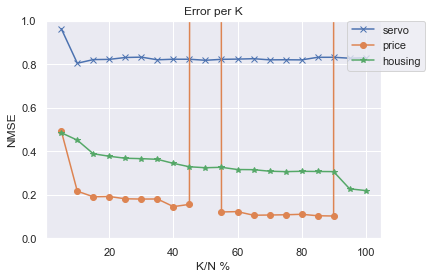

In [53]:
plt.figure()
plt.title("Error per K")
plt.plot(np.arange(5,105,5),servo_errors,"-x",label="servo")
plt.plot(np.arange(5,105,5),price_errors,"-o",label="price")
plt.plot(np.arange(5,105,5),housing_errors,"-*",label="housing")
#plt.plot(np.arange(5,105,5),abalone_errors,"-^",label="abalone")
plt.xlabel("K/N %")
plt.ylabel("NMSE")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.ylim((0.,1.))
plt.show()

### 2.6 Optimal K value over different runs

<Figure size 432x288 with 0 Axes>

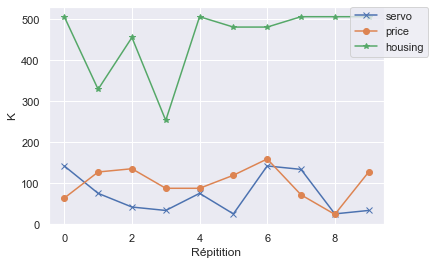

In [54]:
def optimal_k_over(x,y,name):
    x = StandardScaler().fit_transform(x)
    x,y = randomize(x,y)
    y = y.reshape((len(y),1))
    L = []
    for i in range(10):  
        li = []
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3)
        for j in np.arange(5,105,5):
            if name == 'r':
                clf = MLM(rp_number=j/100)
            elif name == 'c':
                clf = NN_MLM(rp_number=j/100)
            clf.fit(x_train,y_train)
            score = clf.score(x_test,y_test)
            li.append((score,(j/100)*len(x)))
        L.append(sorted(li, key=lambda x: x[0])[-1])
    return L

x,y = preprocessing(servo)
servo_optimal_k = optimal_k_over(x,y,'r')
x,y = preprocessing(price)
price_optimal_k = optimal_k_over(x,y,'r')
x,y = preprocessing(housing)
housing_optimal_k = optimal_k_over(x,y,'r')
#x,y = preprocessing(abalone)
#abalone_optimal_k = optimal_k_over(x,y,'r')

plt.figure()
plt.figure("Optimal K value over different runs")
plt.plot(range(10),[i[1] for i in servo_optimal_k],"-x",label="servo")
plt.plot(range(10),[i[1] for i in price_optimal_k],"-o",label="price")
plt.plot(range(10),[i[1] for i in housing_optimal_k],"-*",label="housing")
#plt.plot(range(10),[i[1] for i in abalone_optimal_k],"-^",label="abalone")
plt.xlabel("Répitition")
plt.ylabel("K")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 3. Test sur des problèmes de classification

In [46]:
print("Breast_cancer shape :",breast_cancer.data.shape)
print("Iris shape :",iris.data.shape)
print("Wine shape :",wine.data.shape)

Breast_cancer shape : (569, 30)
Iris shape : (150, 4)
Wine shape : (178, 13)


### 3.1 Breast cancer

In [20]:
def randomize(x,y):
    data = pd.DataFrame(data=np.c_[x,y])
    df_shuffled=data.sample(frac=1).reset_index(drop=True)
    for i in range(10):
        df_shuffled=df_shuffled.sample(frac=1).reset_index(drop=True)
    arr = df_shuffled.to_numpy()
    n = arr.shape[1]
    return arr[:,:n-1],arr[:,n-1]

In [22]:
x = StandardScaler().fit_transform(breast_cancer.data)
x,y = randomize(x,breast_cancer.target)
s = test(x,y,"c")

i) Mean score in 10 fold = 0.9009837128872645, std = 0.059038036825953856
i) Associated value of rp_number :  0.55


In [101]:
grid_search_param(x,y,'c')

Fitting 5 folds for each of 65 candidates, totalling 325 fits
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.400, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.429, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.25, gamma=0.1, kernel=rbf, score=0.972, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=0.5, gamma=0.1, kernel=rbf, score=0.917, total=   0.0s
[CV] C=0.5, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.5, gamma=0.1, kernel=rbf, score=0.971, total=   0.0s
[CV] C=0.5, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.5, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=0.5, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.5, gamma=0.01, kernel=rbf, score=1.000, total=   0.0s
[CV] C=0.5, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.5, gamma=0.01, kernel=rbf, score=0.944, total=   0.0s
[CV] C=0.5, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.5, gamma=0.01, kernel=rbf, score=0.972, total=   0.0s
[CV] C=0.5, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.5, gamma=0.01, kernel=rbf, score=0.971, total=   0.0s
[CV] C=0.5, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ......... C=4, gamma=0.01, kernel=rbf, score=1.000, total=   0.0s
[CV] C=4, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=4, gamma=0.01, kernel=rbf, score=0.971, total=   0.0s
[CV] C=4, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=4, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=4, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=4, gamma=0.001, kernel=rbf, score=0.944, total=   0.0s
[CV] C=4, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=4, gamma=0.001, kernel=rbf, score=0.972, total=   0.0s
[CV] C=4, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=4, gamma=0.001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=4, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=4, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=4, gamma=0.0001, kernel=rbf ...................................
[CV] .

[CV] ......... C=64, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=64, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=64, gamma=0.1, kernel=rbf, score=0.972, total=   0.0s
[CV] C=64, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=64, gamma=0.1, kernel=rbf, score=0.972, total=   0.0s
[CV] C=64, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=64, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=64, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=64, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=64, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=64, gamma=0.01, kernel=rbf, score=0.944, total=   0.0s
[CV] C=64, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=64, gamma=0.01, kernel=rbf, score=0.944, total=   0.0s
[CV] C=64, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] C=512, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=512, gamma=0.0001, kernel=rbf, score=0.944, total=   0.0s
[CV] C=512, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=512, gamma=0.0001, kernel=rbf, score=0.972, total=   0.0s
[CV] C=512, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=512, gamma=0.0001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=512, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=512, gamma=0.0001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=1024, gamma=1, kernel=rbf .....................................
[CV] ......... C=1024, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=1024, gamma=1, kernel=rbf .....................................
[CV] ......... C=1024, gamma=1, kernel=rbf, score=0.667, total=   0.0s
[CV] C=1024, gamma=1, kernel=rbf .....................................
[CV] ......... C=1024, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    1.3s finished


In [23]:
clf = SVC(C=4, gamma=0.1)
scores = cross_val_score(clf,x,y.reshape(len(y)),cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.9560776942355889, std = 0.025097798045085405


### 3.2 Dataset Iris

In [90]:
x = StandardScaler().fit_transform(iris.data)
x,y = randomize(x,iris.target)
s = test(x,y,"c")

i) Mean score in 10 fold = 0.9148240278530608, std = 0.0783335657394679
i) Associated value of rp_number :  0.2


In [108]:
grid_search_param(x,y,'c')

Fitting 5 folds for each of 65 candidates, totalling 325 fits
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.933, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.933, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.25, gamma=0.1, kernel=rbf, score=0.867, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ..... C=0.5, gamma=0.0001, kernel=rbf, score=0.867, total=   0.0s
[CV] C=0.5, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.5, gamma=0.0001, kernel=rbf, score=0.900, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.900, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.933, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ........... C=16, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=16, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=16, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=16, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=16, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=16, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=16, gamma=0.1, kernel=rbf, score=0.933, total=   0.0s
[CV] C=16, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=16, gamma=0.1, kernel=rbf, score=0.933, total=   0.0s
[CV] C=16, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=16, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=16, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=16, gamma=0.01, kernel=rbf, score=0.967, total=   0.0s
[CV] C=16, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ....... C=256, gamma=0.01, kernel=rbf, score=1.000, total=   0.0s
[CV] C=256, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=256, gamma=0.001, kernel=rbf, score=0.967, total=   0.0s
[CV] C=256, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=256, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=256, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=256, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=256, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=256, gamma=0.001, kernel=rbf, score=0.933, total=   0.0s
[CV] C=256, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=256, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=256, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=256, gamma=0.0001, kernel=rbf, score=0.933, total=   0.0s
[CV] C=256, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    1.1s finished


In [91]:
clf = SVC(C=8, gamma=0.1)
scores = cross_val_score(clf,x,y.reshape(len(y)),cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.9466666666666667, std = 0.04988876515698587


### 3.4 Dataset Wine

In [92]:
x = StandardScaler().fit_transform(wine.data)
x,y = randomize(x,wine.target)
s = test(x,y,"c")

i) Mean score in 10 fold = 1.0, std = 0.0
i) Associated value of rp_number :  0.85


In [112]:
grid_search_param(x,y,'c')

Fitting 5 folds for each of 65 candidates, totalling 325 fits
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.400, total=   0.0s
[CV] C=0.25, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.25, gamma=1, kernel=rbf, score=0.429, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.25, gamma=0.1, kernel=rbf, score=0.972, total=   0.0s
[CV] C=0.25, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.5, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.5, gamma=0.001, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.5, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.5, gamma=0.001, kernel=rbf, score=0.417, total=   0.0s
[CV] C=0.5, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.5, gamma=0.001, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.5, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.5, gamma=0.001, kernel=rbf, score=0.400, total=   0.0s
[CV] C=0.5, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.5, gamma=0.001, kernel=rbf, score=0.429, total=   0.0s
[CV] C=0.5, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.5, gamma=0.0001, kernel=rbf, score=0.389, total=   0.0s
[CV] C=0.5, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.5, gamma=0.0001, kernel=rbf, score=0.389, total=   0.0s
[CV] 

[CV] ............ C=8, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=8, gamma=1, kernel=rbf ........................................
[CV] ............ C=8, gamma=1, kernel=rbf, score=0.667, total=   0.0s
[CV] C=8, gamma=1, kernel=rbf ........................................
[CV] ............ C=8, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=8, gamma=1, kernel=rbf ........................................
[CV] ............ C=8, gamma=1, kernel=rbf, score=0.629, total=   0.0s
[CV] C=8, gamma=1, kernel=rbf ........................................
[CV] ............ C=8, gamma=1, kernel=rbf, score=0.743, total=   0.0s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=8, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=8, gamma=0.1, kernel=rbf, score=0.972, total=   0.0s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...... C=64, gamma=0.0001, kernel=rbf, score=0.972, total=   0.0s
[CV] C=64, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=64, gamma=0.0001, kernel=rbf, score=0.944, total=   0.0s
[CV] C=64, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=64, gamma=0.0001, kernel=rbf, score=0.972, total=   0.0s
[CV] C=64, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=64, gamma=0.0001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=64, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=64, gamma=0.0001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=128, gamma=1, kernel=rbf ......................................
[CV] .......... C=128, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=128, gamma=1, kernel=rbf ......................................
[CV] .......... C=128, gamma=1, kernel=rbf, score=0.667, total=   0.0s
[CV] C=128, gamma=1, kernel=rbf ......................................
[CV] .

{'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=4, gamma=0.1)


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    1.2s finished


In [94]:
clf = SVC(C=4, gamma=0.1)
scores = cross_val_score(clf,x,y,cv=10)
print("i) Mean score in 10 fold = {}, std = {}".format(scores.mean(),scores.std()))

i) Mean score in 10 fold = 0.9830065359477125, std = 0.025971655537654292


In [24]:
arr =np.array(([0.91,0.92,0.99],[0.95,0.94,0.97]))
pd.DataFrame(data=arr,columns=["Boston house","Iris","Wine"],index=["MLM (Accuracy)","SVM (Accuracy)"])

,Boston house,Iris,Wine
MLM (Accuracy),0.91,0.92,0.99
SVM (Accuracy),0.95,0.94,0.97


### 3.5 Evolution de l'erreur en fonction du nombre de point références 

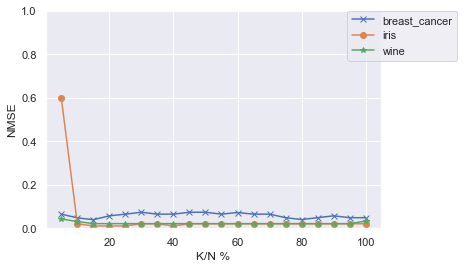

In [34]:
def compute_errors_c(x,y):
    x = StandardScaler().fit_transform(x)
    x,y = randomize(x,y)
    L = []
    for i in np.arange(5,105,5):  
        clf = NN_MLM(rp_number=i/100)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3,random_state=42)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        L.append(mean_squared_error(y_pred,y_test)/mean_squared_error(y_pred,np.zeros(len(y_pred))))
    return L

bc_mlm = compute_errors_c(breast_cancer.data,breast_cancer.target)
iris_mlm = compute_errors_c(iris.data,iris.target)
wine_mlm = compute_errors_c(wine.data,wine.target)

plt.figure()
plt.title("Error per K/N %")
plt.plot(np.arange(5,105,5),bc_mlm,"-x",label="breast_cancer")
plt.plot(np.arange(5,105,5),iris_mlm,"-o",label="iris")
plt.plot(np.arange(5,105,5),wine_mlm,"-*",label="wine")
plt.xlabel("K/N %")
plt.ylabel("NMSE")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.ylim((0.,1.))
plt.show()

### 3.6 Optimal K value over different runs

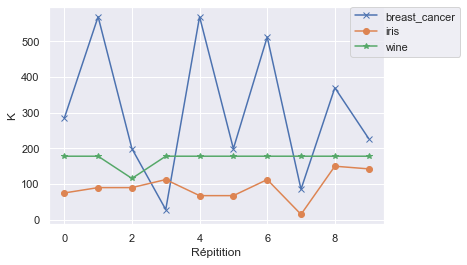

In [40]:


bc_mlm = optimal_k_over(breast_cancer.data,breast_cancer.target,'c')
iris_mlm = optimal_k_over(iris.data,iris.target,'c')
wine_mlm = optimal_k_over(wine.data,wine.target,'c')

plt.figure()
plt.plot(range(10),[i[1] for i in bc_mlm],"-x",label="breast_cancer")
plt.plot(range(10),[i[1] for i in iris_mlm],"-o",label="iris")
plt.plot(range(10),[i[1] for i in wine_mlm],"-*",label="wine")
plt.xlabel("Répitition")
plt.ylabel("K")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 4. Autres test

In [6]:
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification,make_moons,make_circles

names = ["Nearest Neighbors", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Neural Net",
         "Naive Bayes","MLMC","NN_MLM"]
####################################
classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    MLMC(.3),
    NN_MLM(.3)]
scores = []
############################## 
def melange(x,y):
    x = StandardScaler().fit_transform(x).astype('float64')
    u = np.zeros((len(x),3))
    u[:,:2] = x
    u[:,2] = y
    for i in range(10):
        np.random.shuffle(u)
    return u[:,:2],u[:,2]
###################################
def optimal_k(name,x,y):
    score_max = 0.
    best_k = 0.
    for i in np.arange(5,105,5):  
        if name == "MLMC":
            clf = MLMC(rp_number=i/100)
        if name == "NN_MLM":
            clf = NN_MLM(rp_number=i/100)
        if name == "FCM_MLM":
            clf = FCM_MLM(rp_number=i/100)
        score = cross_val_score(clf,x,y,cv=10).mean()
        if score > score_max:
            score_max  = score
            best_k = i/100
    return best_k
###################################
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]
#################################
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = melange(ds[0],ds[1])
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
    
        # iterate over classifiers
    L = []
    for name, clf in zip(names, classifiers):
        if name in ["MLMC","NN_MLM"]:
            y = y.reshape((len(y),1)) 
            y_train = y_train.reshape((len(y_train),1)) 
            y_test = y_test.reshape((len(y_test),1)) 
            k = optimal_k(name,X,y)
            if name == "MLMC":
                clf = MLMC(k)
            if name == "NN_MLM":
                clf = NN_MLM(k)
            
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        score = mean_squared_error(y_pred,y_test)
        L.append(score)
        print("classifier : {}, score : {}".format(name,score))
    scores.append(L)
    print("\n")

classifier : Nearest Neighbors, score : 0.025
classifier : RBF SVM, score : 0.025
classifier : Gaussian Process, score : 0.05
classifier : Decision Tree, score : 0.075
classifier : Neural Net, score : 0.125
classifier : Naive Bayes, score : 0.15
classifier : MLMC, score : 0.031901769291724516
classifier : NN_MLM, score : 0.05


classifier : Nearest Neighbors, score : 0.15
classifier : RBF SVM, score : 0.075
classifier : Gaussian Process, score : 0.1
classifier : Decision Tree, score : 0.125
classifier : Neural Net, score : 0.1
classifier : Naive Bayes, score : 0.125
classifier : MLMC, score : 0.07871317848295276
classifier : NN_MLM, score : 0.075


classifier : Nearest Neighbors, score : 0.1
classifier : RBF SVM, score : 0.075
classifier : Gaussian Process, score : 0.075
classifier : Decision Tree, score : 0.05
classifier : Neural Net, score : 0.075
classifier : Naive Bayes, score : 0.1
classifier : MLMC, score : 0.04459279143293791
classifier : NN_MLM, score : 0.075




In [63]:
pd.DataFrame(data=scores,columns=names,index=["make moon","make circle","linearly separable"])

,Nearest Neighbors,RBF SVM,Gaussian Process,Decision Tree,Neural Net,Naive Bayes,MLMC,NN_MLM
make moon,0.875,0.900,0.900,0.850,0.875,0.875,0.701225,0.70000
make circle,0.875,0.925,0.950,0.900,0.925,0.875,0.702947,0.69697
linearly separable,0.950,0.950,0.975,0.875,0.950,0.950,0.844479,0.90000


In [64]:
mk_m = [[],[]]
mk_c = [[],[]]
mk_l = [[],[]]
for i in range(100):
    if datasets[0][1][i] == 0:
        mk_m[0].append(datasets[0][0][i])
    else :
        mk_m[1].append(datasets[0][0][i])
        
    if datasets[1][1][i] == 0:
        mk_c[0].append(datasets[1][0][i])
    else :
        mk_c[1].append(datasets[1][0][i])
        
    if datasets[2][1][i] == 0:
        mk_l[0].append(datasets[2][0][i])
    else :
        mk_l[1].append(datasets[2][0][i])

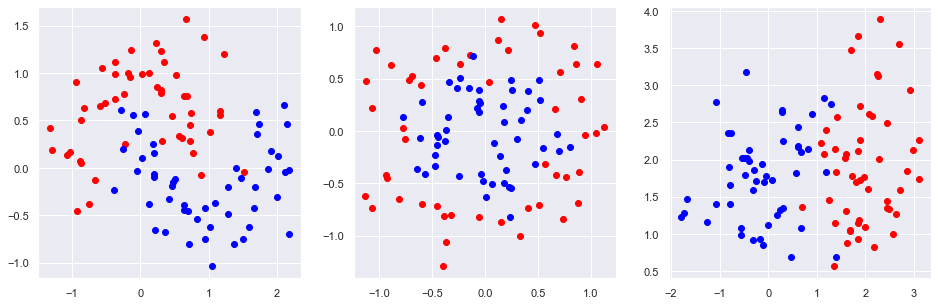

In [80]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.scatter(np.array(mk_m[0])[:,0],np.array(mk_m[0])[:,1],color='red')
plt.scatter(np.array(mk_m[1])[:,0],np.array(mk_m[1])[:,1],color='blue')

plt.subplot(132)
plt.scatter(np.array(mk_c[0])[:,0],np.array(mk_c[0])[:,1],color='red')
plt.scatter(np.array(mk_c[1])[:,0],np.array(mk_c[1])[:,1],color='blue')

plt.subplot(133)
plt.scatter(np.array(mk_l[0])[:,0],np.array(mk_l[0])[:,1],color='red')
plt.scatter(np.array(mk_l[1])[:,0],np.array(mk_l[1])[:,1],color='blue')

plt.show()